# Statistical Model

In [19]:
%load_ext autoreload
%autoreload 2
from glob import glob
from collections import defaultdict
import json
from copy import deepcopy
import os
import pickle

import numpy as np
import pandas as pd
from scipy.stats import energy_distance, wasserstein_distance
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, auc, accuracy_score, confusion_matrix, roc_auc_score

from canary.generator.utils import (
    read_X_y_dicts_from_files, _read_one_file,
    buckets_to_points, X_metric_to_df, y_metric_to_df,
)
from canary.models.metrics import (
    log_bhattacharyya_dist, log_max_diff_dist, log_sum_of_diff_dist, log_wasserstein_dist, log_energy_dist
)
from canary.models.utils import (
    percentile, plot_dists, plot_preds, calculate_dists, _calculate_one_day_dist
)

## Load the data

Loading the data previously generated with `generator` module

In [2]:
DATA_DIR = '/home/aga/canary/data/'

In [3]:
X_train = dict()
for file in sorted(glob(os.path.join(DATA_DIR, '*_X_train.json'))):
    m = file.split('/')[-1].split('_X')[0]
    X_train[m] = json.load(open(file))
    
X_test = dict()
for file in sorted(glob(os.path.join(DATA_DIR, '*_X_test.json'))):
    m = file.split('/')[-1].split('_X')[0]
    X_test[m] = json.load(open(file))

y_anomalies = dict()
for file in sorted(glob(os.path.join(DATA_DIR, '*_y_test.json'))):
    m = file.split('/')[-1].split('_y')[0]
    y_anomalies[m] = json.load(open(file))
    
y_pred = dict()
for m, hist in X_test.items():
    y_pred[m] = dict.fromkeys(hist['data'], 0)

y_pred_proba = dict()
for m, hist in X_test.items():
    y_pred_proba[m] = dict.fromkeys(hist['data'], 0)

## Delete too short merics

The train time series should be at least of length of `LENGTH + 2`, because we need some history to learn from.

In [4]:
metrics = list(X_train.keys())
for metric in metrics:
    if len(X_train[metric]['data'].values()) <= 2:
        del X_train[metric]
        del X_test[metric]

## Calculate the distances on train and test

First, we convert the data from histograms to distanced between next days.

Calculated distances:
 - logarithm of Bhattacharyya distance
 - logarithm of Wasserstein distance
 - logarithm of energy distance
 - logarithm of maximum difference between corresponding buckets
 - logarithm of sum of difference between corresponding buckets
 
Logarithm is a form of normalization of the distances.
The distances were chosen arbitrary, the more diversed distances, the better.

In [ ]:
bucket_dists = [log_bhattacharyya_dist, log_max_diff_dist, log_sum_of_diff_dist]
points_dists = [log_wasserstein_dist, log_energy_dist]
dists_train = calculate_dists(X_train, bucket_dists, points_dists)
pickle.dump(dict(dists_train), open(os.path.join(DATA_DIR, 'dists_train'), 'wb'))

Let's see one example of conversion between histogram (bottom) and distances (top) on the train set. We can clearly see the potential anomaly on the distance plot.

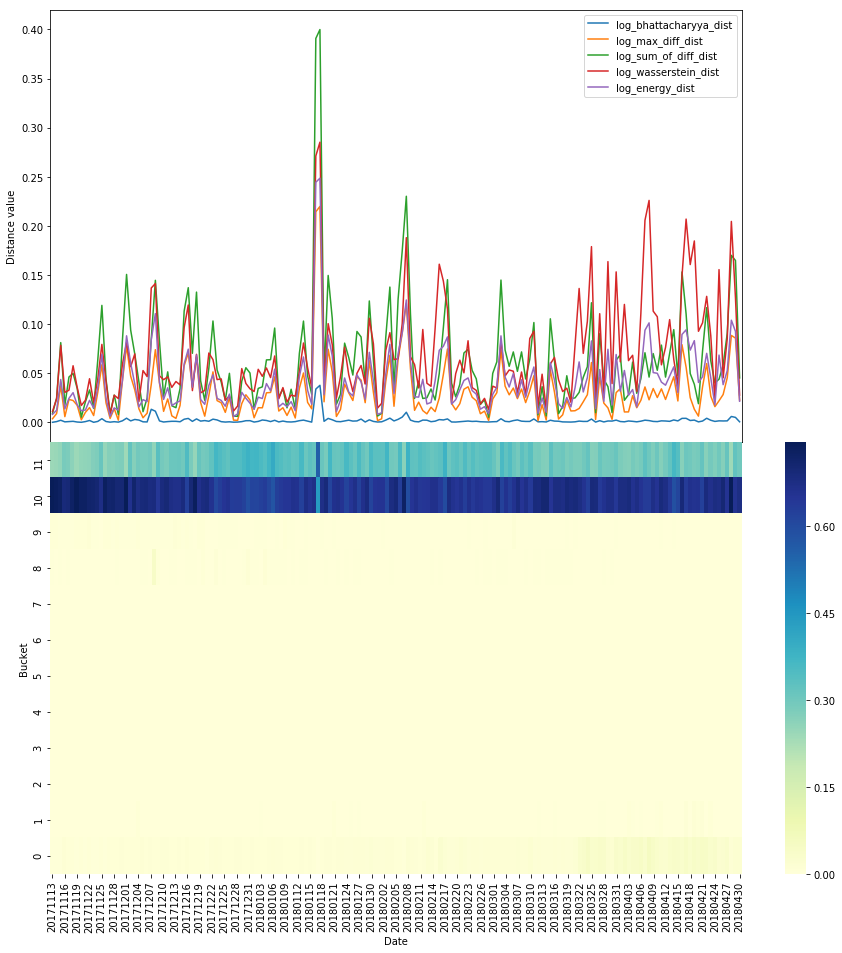

In [60]:
metric = 'A11Y_CONSUMERS'
dists_df = pd.DataFrame(dists_train[metric])
plot_dists(dists_df, X_train[metric])

## Predict on test and calculate ROC AUC

For each observation the distances from the previous day are calculated. Then for each distance the percentiles are calculated based on the training data. Since we have multiple distance functions, we have multiple percentiles. We use `np.mean` to aggregate those percentiles into one value. If that value is larger then the `threshold`, we mark the observation as an anomaly. For the next observation we exclude the anomaly from calculating the distances.

metric:  A11Y_CONSUMERS
auc:  0.9967105263157894


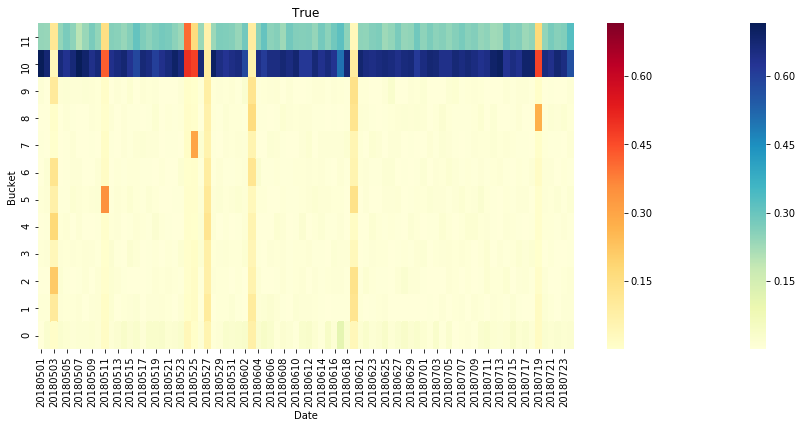

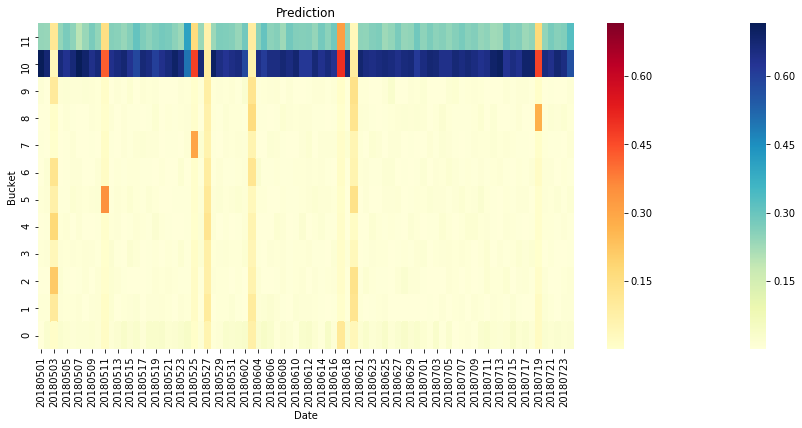

metric:  DEVTOOLS_LAYOUTVIEW_OPENED_COUNT
auc:  0.977027027027027


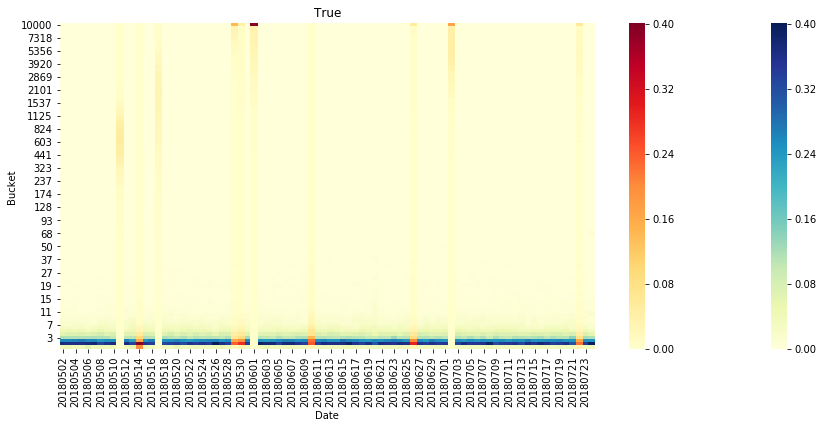

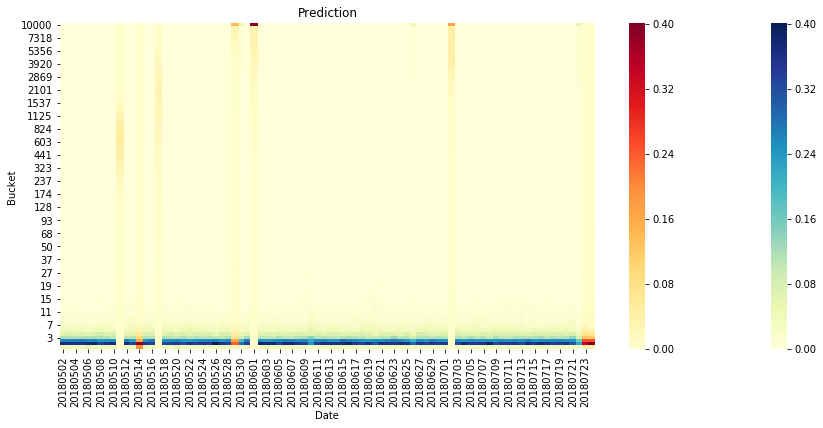

metric:  FX_TAB_SWITCH_UPDATE_MS
auc:  0.8883101851851851


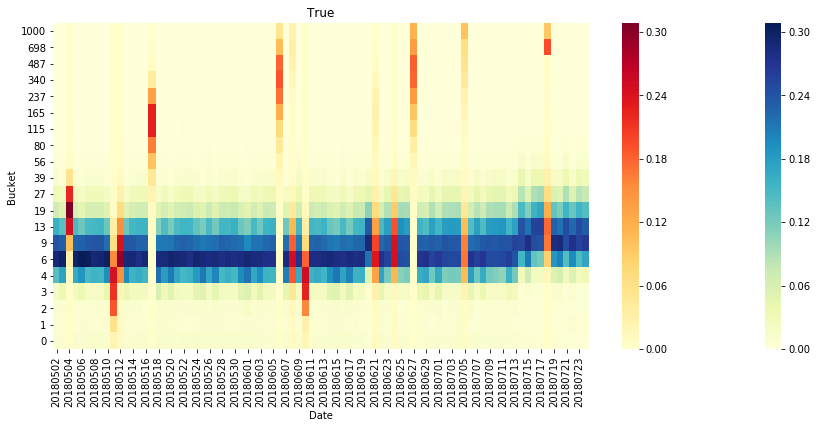

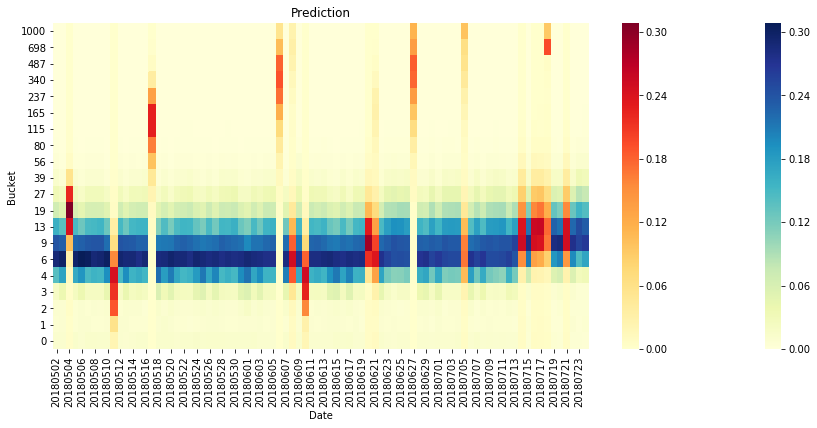

metric:  MASTER_PASSWORD_ENABLED
auc:  0.962171052631579


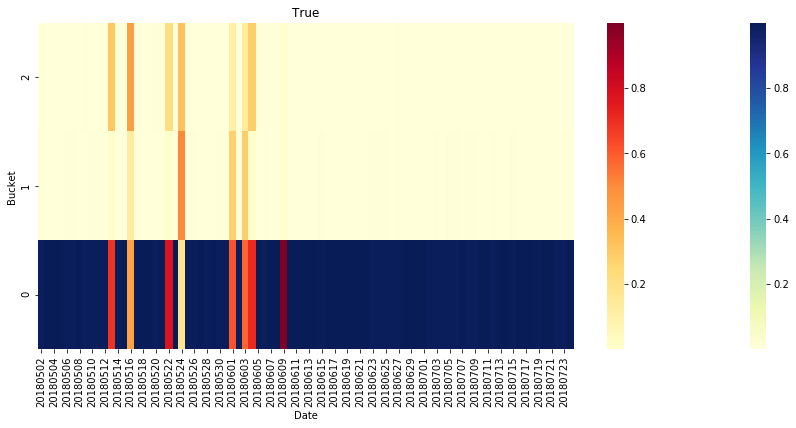

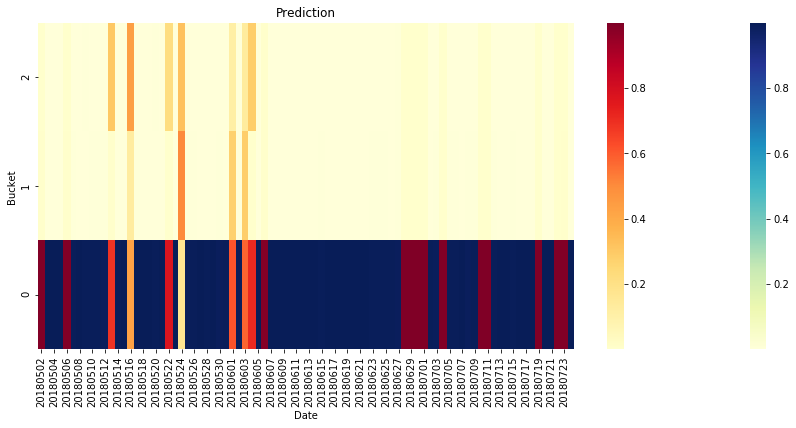

metric:  PREDICTOR_TOTAL_PRECONNECTS_UNUSED
auc:  0.5


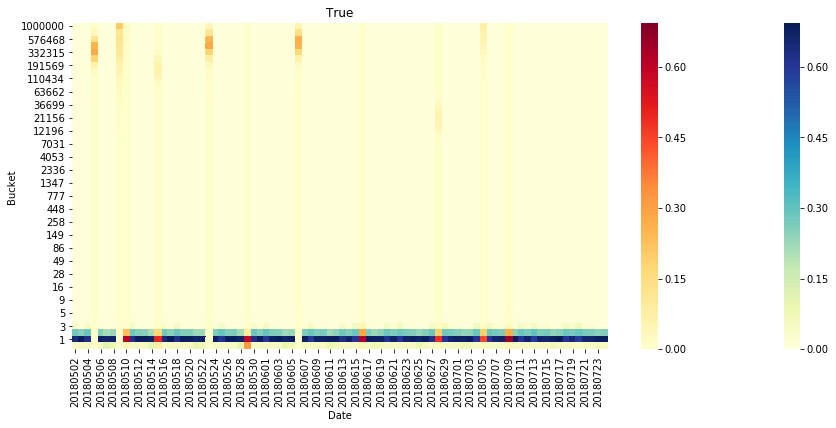

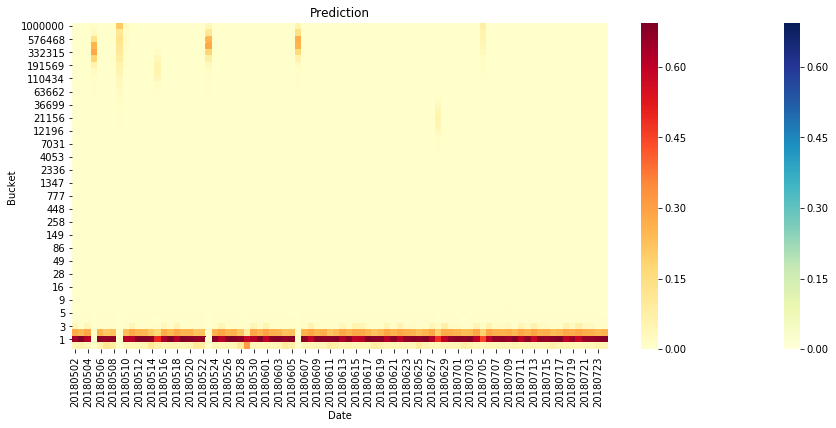

Bad metric:  SHUTDOWN_PHASE_DURATION_TICKS
Bad metric:  SIMPLE_MEASURES_ADDONMANAGER
metric:  SIMPLE_MEASURES_SESSIONRESTOREINIT
auc:  0.9986486486486486


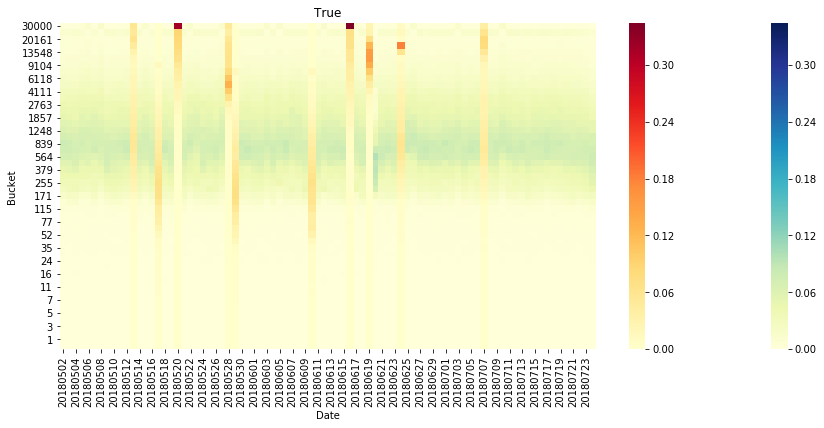

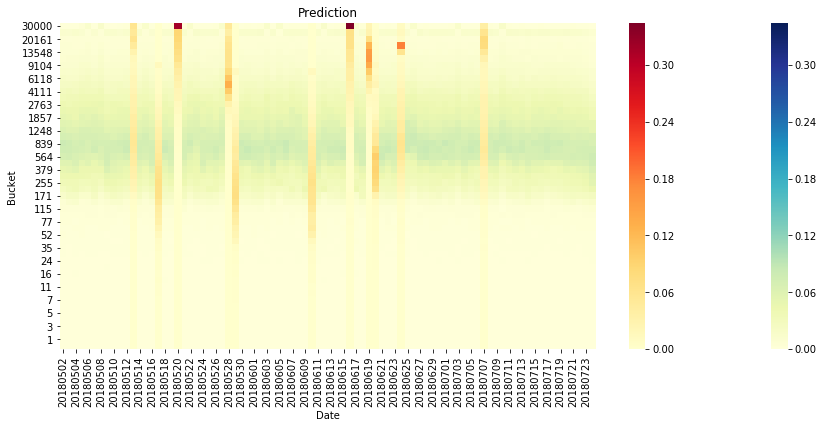

Bad metric:  SIMPLE_MEASURES
metric:  UPDATE_PING_COUNT_EXTERNAL
auc:  0.5


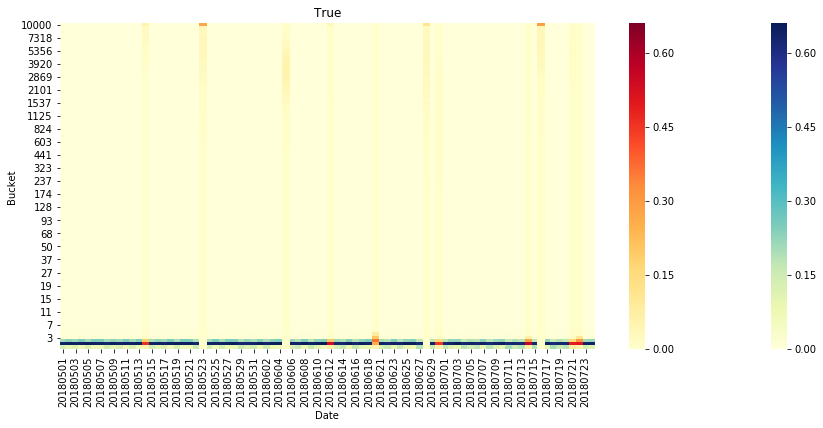

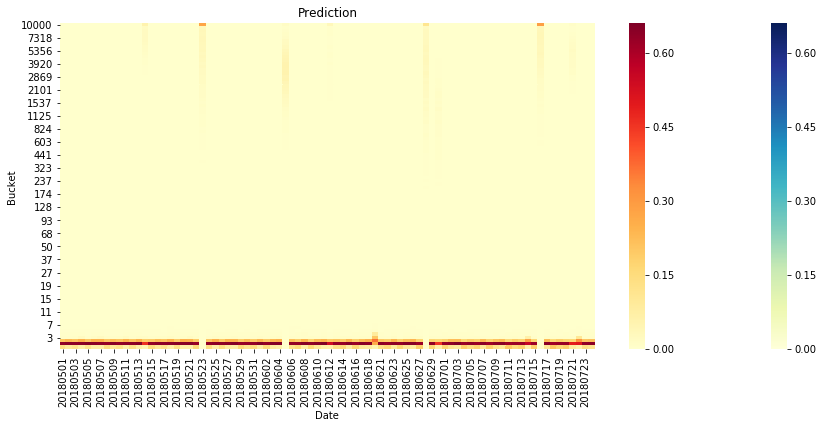

Bad metric:  USE_COUNTER2_DEPRECATED
metric:  USE_COUNTER2_IDBMUTABLEFILE_GETFILE_PAGE
auc:  0.905952380952381


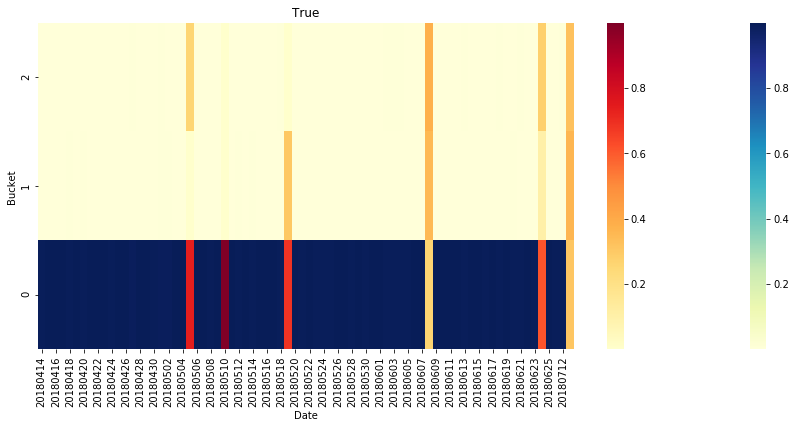

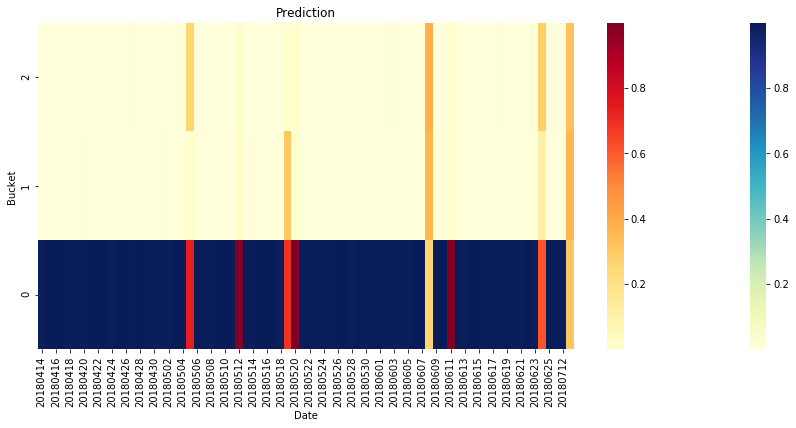

Bad metric:  USE_COUNTER2
metric:  WEB_NOTIFICATION_SHOWN
auc:  0.9491180461329716


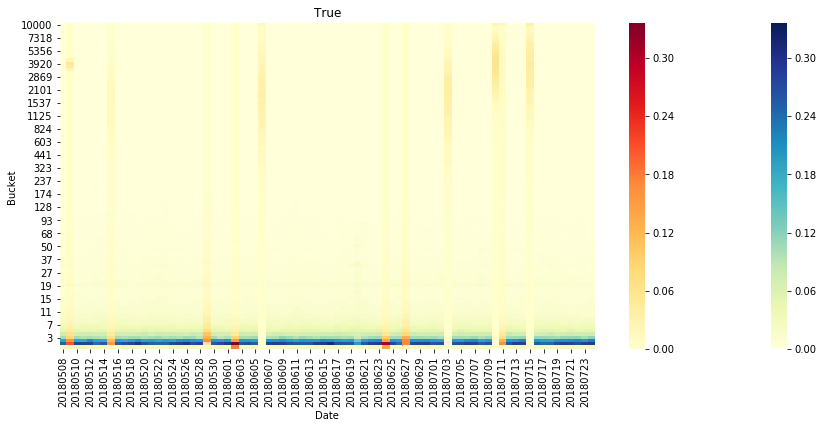

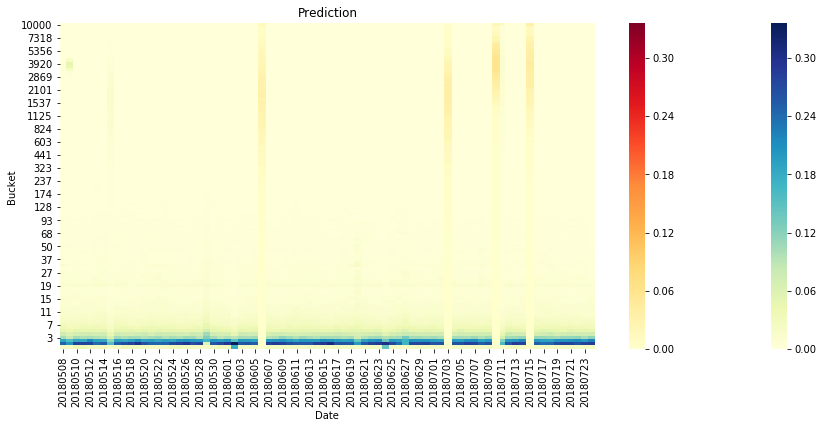

In [22]:
results = {}
threshold = 0.99
func = np.mean  # the mean function proved to have the best ROC AUC score
auc_arr = []
for i, m in enumerate(X_test.keys()):
    try:
        # add one last day from train
        hist_copy = deepcopy(X_test[m])
        last_date = sorted(X_train[m]['data'].keys())[-1]
        hist_copy['data'][last_date] = X_train[m]['data'][last_date]
        points = buckets_to_points(hist_copy)

        # date pairs
        dates = sorted(hist_copy['data'].keys())
        date_pairs = [(dates[i], dates[i+1]) for i in range(len(dates) - 1)]
        anomaly = False
        
        # predictions with skipping anomalies
        for d1, d2 in date_pairs:
            if len(hist_copy['data'][d1]) == len(hist_copy['data'][d2]):
                if anomaly:
                    d1 = old_d1
                    anomaly = False
                dists_day = _calculate_one_day_dist(hist_copy, points, d1, d2, bucket_dists, 
                                                    points_dists, m)
                perc_day = {dist.__name__: percentile(dists_train[m][dist.__name__], dists_day[dist.__name__]) 
                            for dist in bucket_dists + points_dists}
                perc = func(list(perc_day.values()))
                y_pred_proba[m][d2] = perc
                if perc > threshold:
                    y_pred[m][d2] = 1
                    anomaly = True
                    old_d1 = d1
                else:
                    y_pred[m][d2] = 0
        
        # make data frames with anomalies
        y_test_df = y_metric_to_df(y_anomalies[m])
        y_pred_proba_df = y_metric_to_df(y_pred_proba[m])
        y_pred_anom_df = pd.DataFrame(y_pred[m], index=[0]).transpose()
        if len(np.unique(np.array(y_test_df[0]))) > 1:
            auc_score = roc_auc_score(np.array(y_test_df[0]), np.array(y_pred_proba_df[0]))
            auc_arr.append(auc_score)
            if i % 200 == 0: 
                print('metric: ', m)
                print('auc: ', auc_score)
                plot_preds(X_metric_to_df(X_test[m]), y_test_df, y_pred_anom_df)
    except KeyError:
        print('Bad metric: ', m)
results[func.__name__] = auc_arr
pickle.dump(y_pred, open(os.path.join(DATA_DIR, 'preds_anom_statistical'), 'wb'))
pickle.dump(y_pred_proba, open(os.path.join(DATA_DIR, 'preds_proba_anom_statistical'), 'wb'))

In [23]:
print([(k, np.mean(v)) for k, v in results.items()])

[('mean', 0.8424719025378878)]


The average ROC AUC for all metrics is 0.84.